In [2]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

# Tối ưu hoá quá trình truy vấn hình ảnh sử dụng mô hình CLIP và cơ sở dữ liệu
vector

In [4]:
ROOT = "data"
CLASS_NAME = sorted(list(os.listdir(f"{ROOT}/train")))
HNSW_SPACE = "hnsw:space"

In [5]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + "/" + filename
            files_path.append(filepath)
    return files_path

In [6]:
data_path = f"{ROOT}/train"
files_path = get_files_path(path=data_path)
files_path[:10]

['data/train/African_crocodile/n01697457_14906.JPEG',
 'data/train/African_crocodile/n01697457_8136.JPEG',
 'data/train/African_crocodile/n01697457_18587.JPEG',
 'data/train/African_crocodile/n01697457_5586.JPEG',
 'data/train/African_crocodile/n01697457_8331.JPEG',
 'data/train/African_crocodile/n01697457_1331.JPEG',
 'data/train/African_crocodile/n01697457_104.JPEG',
 'data/train/African_crocodile/n01697457_260.JPEG',
 'data/train/African_crocodile/n01697457_10393.JPEG',
 'data/train/African_crocodile/n01697457_85.JPEG']

In [7]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448, 448))
    images = [query_image]
    class_name = []
    for id_img in results["ids"][0]:
        id_img = int(id_img.split("_")[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448, 448))
        images.append(img)
        class_name.append(img_path.split("/")[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis("off")  # Hide axes
    # Display the plot
    plt.show()

# Truy vấn ảnh với L2 Collection

In [8]:
embedding_function = OpenCLIPEmbeddingFunction()


def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

/opt/homebrew/anaconda3/envs/image-retrieval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/anaconda3/envs/image-retrieval/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user 

In [9]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f"id_{id_filepath}")
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(embeddings=embeddings, ids=ids)

In [10]:
# Create a Chroma Client
chroma_client = chromadb.PersistentClient(path="./chromadb/persisted")
# Create a collection
l2_collection = chroma_client.get_or_create_collection(
    name="l2_collection", metadata={HNSW_SPACE: "l2"}
)
add_embedding(collection=l2_collection, files_path=files_path)

595it [00:29, 20.43it/s]


In [9]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results,  # how many results to return
    )
    return results

In [10]:
test_path = f"{ROOT}/test"
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

In [11]:
l2_results

{'ids': [['id_14', 'id_19', 'id_16', 'id_18', 'id_11']],
 'distances': [[0.4049471616744995,
   0.4137755036354065,
   0.500676155090332,
   0.5080239176750183,
   0.5198472142219543]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

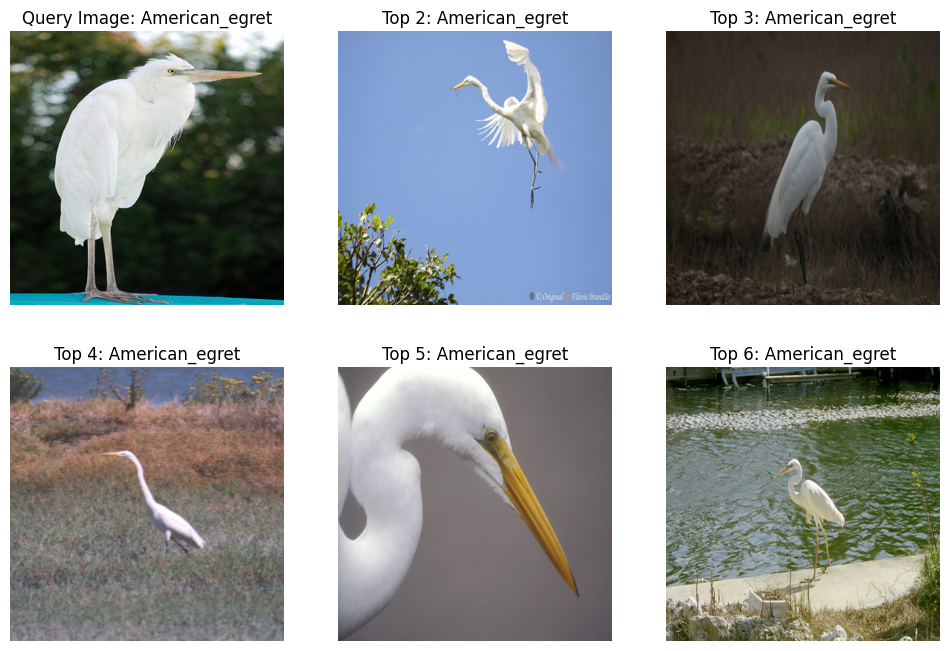

In [12]:
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

# Truy vấn ảnh với Cosine Similarity Collection

In [13]:
# Create a collection
cosine_collection = chroma_client.get_or_create_collection(
    name="Cosine_collection", metadata={HNSW_SPACE: "cosine"}
)
add_embedding(collection=cosine_collection, files_path=files_path)

595it [00:30, 19.78it/s]


In [14]:
test_path = f"{ROOT}/test"
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)

In [15]:
cosine_results

{'ids': [['id_14', 'id_19', 'id_16', 'id_18', 'id_11']],
 'distances': [[0.20247358083724976,
   0.2068878412246704,
   0.25033819675445557,
   0.2540121078491211,
   0.25992363691329956]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

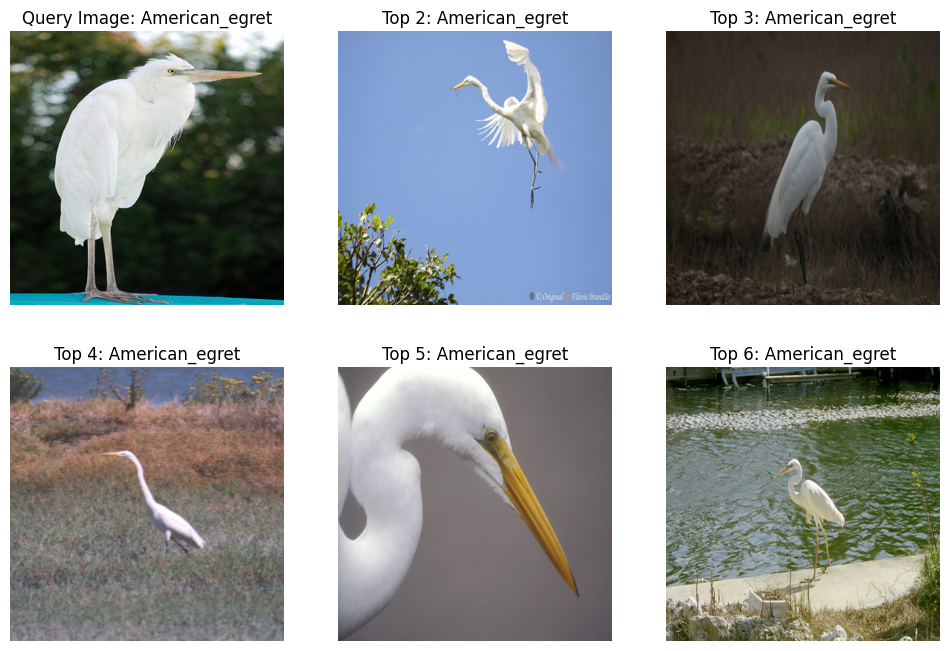

In [16]:
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)